## 1. Introduction
<hr>

Customer segmentation is one of the most important metrices for growing companies to evaluate. While it's not the happiest measure, it's a number that give companies the hard truth about its customer retention strategy.

### What is Customer Churn?
Customer Churn is the percentage of customers that stopped using company's product/service during a certain time frame. The calculation for customer churn is diving the number of customers company lost during that time period by the number of customers company had at the beginning of that time period.

For example,

If company had 400 customers at the beginning of the year and end with 360, means company's churn rate is 10%, because compant lost 10% of the the customer from the base. Most companies try to decrease churn rate as 0%.


### Datasets, Features and Target value
Source : https://www.kaggle.com/blastchar/telco-customer-churn ( IBM Sample dataset)

Here, IBM provided customer data for Telco industry to predict behavior of the customers. Main objective is that to analyze customer behaviors and develop strategies for customer retention.

Assumption - Here, data source has not provided any information related to time; So I have assumed that all the customers are for same interval. 

Dataset has information related,

#### Demographic:

- Gender - Male / Female <br>
- Age range - In terms of Partner, Dependent and Senior Citizen

#### Services:

- Phone service - If customer has Phone service, then services related to Phone like;
    - Multiline Phone service
- Internet Service - If customer has Internet service, then services related to Internet like;
    - Online security
    - Online backup
    - Device protection
    - Tech support
    - Streaming TV
    - Streaming Movies

#### Account type:

- Tenure - How long customer is with the company?
- Contract type - What kind of contract they have with a company? Like
    - Monthly bases
    - On going bases - If on going bases, then One month contract or Two year contract
- Paperless billing - Customer is paperless billion option or not?
- Payment method - What kind of payment method customer has?
    - Mailed check
    - Electronic check
    - Credit card (Automatic)
    - Bank transfer (Automatic)

#### Usage:

- Monthly charges
- Total charges

#### Target:

- Churn - Whether customer left the company or still with the company?

### Problem Description
Here, our objective is to analyze customer behaviour in terms of 
- What kind of customers are leaving company?

#### Retention Strategy
- Find out existing customers churn probability and apply retention strategy on high probability churn customers

### Content
1. Loading and cleaning data
2. Class Imbalance
3. Predicting using logistic regression
4. Model evaluation

## 1. Load and cleaning data
<hr>

In [168]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

sns.set()
%matplotlib inline

#### Data importing and preprocessing

In [169]:
# load data from file to existing envrionment
def load_data(filepath,format='csv'):
    if format == 'csv':
        return pd.read_csv(filepath)
    elif format == 'xlsx':
        return pd.read_excel(filepath)

In [170]:
df_raw = load_data("WA_Fn-UseC_-Telco-Customer-Churn.csv","csv")
df_raw.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Dimensionality & Sanity check

In [171]:
df_raw.shape

(7043, 21)

Dataset has **7043 observations** and **21 features**

In [172]:
# feature exploration

df_raw.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [173]:
# Checking missing / NULL values

df_raw.isnull().any()

customerID          False
gender              False
SeniorCitizen       False
Partner             False
Dependents          False
tenure              False
PhoneService        False
MultipleLines       False
InternetService     False
OnlineSecurity      False
OnlineBackup        False
DeviceProtection    False
TechSupport         False
StreamingTV         False
StreamingMovies     False
Contract            False
PaperlessBilling    False
PaymentMethod       False
MonthlyCharges      False
TotalCharges        False
Churn               False
dtype: bool

In [174]:
# Duplicate value check

df_raw.duplicated().any()

np.False_

In [175]:
# Exploring data types of each feature

df_raw.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

We need to rename columns into proper format and need to transform columns like Partner, Dependents and so on to similar format for furture analysis.

Also, need to change data type of TotalCharges to float.

In [176]:
# Rename column names and map values for numeric calculation
def clean_data(df):
    df.rename(columns={'gender':'Gender'
                       ,'customerID':'CustomerID'
                       ,'Contract':'ContractType'
                       ,'InternetService':'InternetServiceType'
                       ,'tenure':'Tenure'
                      }
              ,inplace=True)


    df['Partner'] = df.Partner.map({'Yes':1,'No':0})
    df['Dependents'] = df.Dependents.map({'Yes':1,'No':0})

    df['PhoneService'] = df.PhoneService.map({'Yes':1,'No':0})
    df['MultipleLines'] = df.MultipleLines.map({'Yes':1,'No':0,'No phone service':0})

    df['InternetService'] = df.InternetServiceType.map({'DSL':1,'Fiber optic':1,'No':0})
    df['OnlineSecurity'] = df.OnlineSecurity.map({'Yes':1,'No':0,'No internet service':0})
    df['OnlineBackup'] = df.OnlineBackup.map({'Yes':1,'No':0,'No internet service':0})
    df['DeviceProtection'] = df.DeviceProtection.map({'Yes':1,'No':0,'No internet service':0})
    df['TechSupport'] = df.TechSupport.map({'Yes':1,'No':0,'No internet service':0})
    df['StreamingTV'] = df.StreamingTV.map({'Yes':1,'No':0,'No internet service':0})
    df['StreamingMovies'] = df.StreamingMovies.map({'Yes':1,'No':0,'No internet service':0})

    df['IsContracted'] = df.ContractType.map({'One year':1,'Two year':1,'Month-to-month':0})
    df['PaperlessBilling'] = df.PaperlessBilling.map({'Yes':1,'No':0})
    df['Churn'] = df.Churn.map({'Yes':1,'No':0})
    
    df.loc[df['TotalCharges']==' ','TotalCharges'] = np.nan
    df['TotalCharges'] = df['TotalCharges'].astype('float64')
    df.loc[df['TotalCharges']==np.nan,'TotalCharges'] = df['MonthlyCharges'] * df['Tenure']
    
    return df

In [177]:
# clean, shuffle and reindexing traing data set -- shuffling may improve cross validation accuracy
clean_df = shuffle(clean_data(df_raw.copy())).reset_index()
clean_df.head()

,index,CustomerID,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetServiceType,...,StreamingTV,StreamingMovies,ContractType,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,InternetService,IsContracted
0,6861,6692-UDPJC,Female,0,1,1,14,1,1,Fiber optic,...,1,0,Month-to-month,1,Electronic check,91.65,1301.00,1,1,0
1,627,6797-UCJHZ,Female,1,1,0,66,1,1,Fiber optic,...,1,1,One year,0,Credit card (automatic),104.60,6819.45,0,1,1
2,1618,8017-LXHFA,Female,1,0,0,23,1,0,Fiber optic,...,1,1,Month-to-month,1,Electronic check,94.75,2293.60,1,1,0
3,4570,1386-ZIKUV,Male,0,0,0,7,1,0,No,...,0,0,Month-to-month,1,Mailed check,18.95,130.55,0,0,0
4,4748,3125-RAHBV,Male,0,0,0,22,1,0,No,...,0,0,One year,0,Credit card (automatic),20.30,467.15,0,0,1


In [178]:
# define variables

categorical_vars = ['Gender','InternetServiceType','PaymentMethod','ContractType']
binary_vars = ['SeniorCitizen','Partner','Dependents','PhoneService','MultipleLines','OnlineSecurity','OnlineBackup'
               ,'DeviceProtection','TechSupport','StreamingTV', 'StreamingMovies','PaperlessBilling','InternetService'
               , 'IsContracted']
numeric_vars = ['Tenure','MonthlyCharges']
target_var = 'Churn'

In [179]:
# encode categorical data to numeric using One-hot encoding method
def one_hot_encoding_features_df(df, cat_feat):
    cat_df = pd.get_dummies(df[cat_feat])
    return cat_df


In [180]:
# merge categorical, numerical, and binary data
def merge_df(categorical,binary,numerical):
    return pd.concat([categorical,binary,numerical],axis = 1)


In [181]:
feature_df = merge_df(one_hot_encoding_features_df(clean_df,categorical_vars), clean_df[binary_vars] ,clean_df[numeric_vars])
target_df = clean_df[target_var]

In [182]:
def train_test_split_fn(feature, target , test_size=None, random_state=0):
    return train_test_split(feature, target, test_size = test_size,random_state = random_state )

In [183]:
x_train, x_test, y_train , y_test = train_test_split_fn(feature_df,target_df,test_size=0.2)

## 2. Class Imbalance

<hr>


In [184]:
clean_df.Churn.value_counts(normalize=True)

Churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64

Text(0.5, 1.0, 'Distribution of churn subs')

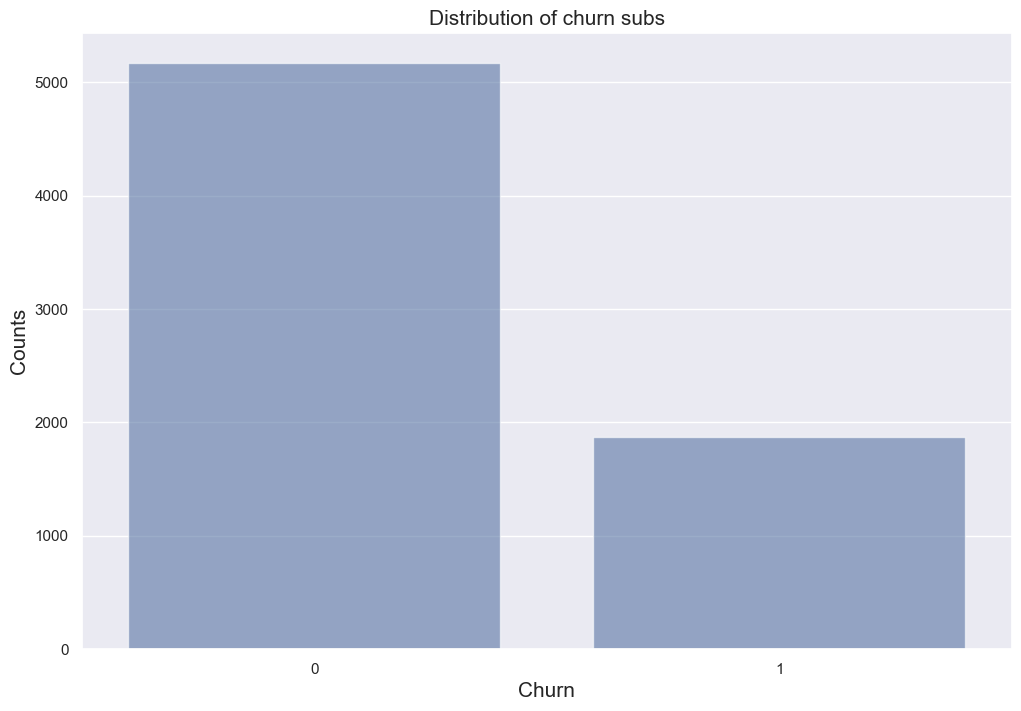

In [185]:
plt.figure(figsize=(12,8))
churn_cnt = clean_df.Churn.value_counts()
sns.barplot(x=churn_cnt.index, y=churn_cnt.values, alpha=0.6)
plt.xlabel("Churn",fontsize=15)
plt.ylabel("Counts",fontsize=15)
plt.title("Distribution of churn subs",fontsize=15)

### How to treat imbalanced datasets

1. Oversampling - Balance it out by adding more under sample data
2. Undersampling - Balance it out by removing over sample data


#### Methods

- Resample 
    - Up sampling - You randomly resample minority class to create new data
    - Down sampling - You randomly resample majority class to remove some data  
- SMOTE
    - You use nearest neighbors of the minority class to create new synthetic data

In [186]:
# Upsampling using minority class

x_train_us , y_train_us = resample(x_train[y_train == 1]
                                  ,y_train[y_train == 1]
                                  , replace = True  
                                  , n_samples = x_train[y_train == 0].shape[0]
                                  , random_state = 1)

x_train_us = pd.concat([x_train_us, x_train[y_train == 0]], axis = 0)
y_train_us = pd.concat([y_train_us, y_train[y_train == 0]], axis = 0)

#Upsampling using SMOTE
sm = SMOTE(random_state=12, sampling_strategy=1.0)
x_train_sm , y_train_sm = sm.fit_resample(x_train,y_train)


# Downsampling using majority class
x_train_ds , y_train_ds = resample(x_train[y_train == 0]
                                   , y_train[y_train == 0]
                                   , replace=True
                                   , n_samples = x_train[y_train == 1].shape[0]
                                   , random_state = 1)

x_train_ds = pd.concat([x_train_ds, x_train[y_train == 1]], axis = 0)
y_train_ds = pd.concat([y_train_ds, y_train[y_train == 1]], axis = 0)


print("original shape: ",x_train.shape)
print("Upsampling using resample: ", x_train_us.shape)
print("Upsampling using SMOTE: ", x_train_sm.shape)
print("Downsampling using resample: ",x_train_ds.shape)

original shape:  (5634, 28)
Upsampling using resample:  (8274, 28)
Upsampling using SMOTE:  (8274, 28)
Downsampling using resample:  (2994, 28)


In [187]:
from sklearn.model_selection import cross_val_score

samples = {'original': (x_train, y_train)
          , 'Upsampled': (x_train_us, y_train_us)
          , 'SMOTE': (x_train_sm, y_train_sm)
          , 'Downsampled': (x_train_ds, y_train_ds)}

for sample in samples:
    scores = cross_val_score(LogisticRegression(max_iter=1000),  # Increased from default 100
                           samples[sample][0], 
                           samples[sample][1], 
                           cv=5, 
                           scoring='f1')
    print(sample, " : ", scores.mean())
    
    
scores = cross_val_score(LogisticRegression(class_weight='balanced', max_iter=10000),x_train, y_train, cv=5 , scoring = 'f1')
print("Original data with balanced characteristic in logistic model  : ", scores.mean())

original  :  0.583908976310916
Upsampled  :  0.7755222471562477
SMOTE  :  0.8123266598783758
Downsampled  :  0.7688056108620595
Original data with balanced characteristic in logistic model  :  0.6226008159696172


## 3. Predicting using Logistic regression

<hr>

In [188]:
lg_model = LogisticRegression(class_weight='balanced',random_state=42,max_iter=2000)
lg_model.fit(x_train_sm,y_train_sm)

LogisticRegression(class_weight='balanced', max_iter=2000, random_state=42)

### Calcuate Hard and Soft prediction


    Hard prediction: Using predict() method. Predict 0 or 1
    Soft prediction: Using predict_proba() method. Predict value between 0 and 1

In [189]:
print("Hard predict: \n", lg_model.predict(x_test)[:10])

Hard predict: 
 [1 0 0 0 0 1 0 0 1 0]


In soft prediction

First column predict probability of class - **Not chrun customer**<br>
Second column predict probability of class - **Chrun customer**

In [190]:
print("Soft predict: \n", lg_model.predict_proba(x_test)[:10])

Soft predict: 
 [[0.26316334 0.73683666]
 [0.99706019 0.00293981]
 [0.99187994 0.00812006]
 [0.78894826 0.21105174]
 [0.99148688 0.00851312]
 [0.29559644 0.70440356]
 [0.51199598 0.48800402]
 [0.9603966  0.0396034 ]
 [0.27228897 0.72771103]
 [0.99559373 0.00440627]]


## 4. Model evaluation

<hr>

### Confusion Matrix

- **True positive (TP) : Your prediction that customer churn and s/he is**
- **True negative (TN) : Your prediction that customer churn is not chrun and s/he is not**
- **False positive (FP): Your prediction that customer is churn and s/he is not**
- **False negative (FN): Your prediction that curstomer is not churn and s/he is**


<img src='confusion_matrix.png'></img>

### Classification report

- **Precision** : TP / (TP + FP)
    - Focus on your prediction
    - Measure what fraction of your positive class are valid 
    

- **Recall** : TP / (TP + FN) 
    - Focus on your all positive class
    - How often your predictions actually capture the positive class
    - Also called **Sensitivity or TPR**
    
    
- **F1 score**: Tells you the accuracy of the classifier
    - It calculate using combination of precision and recall. 
  
  
- **Support** : Number of samples of the true response that lies in that class



### Recall or Precision ??

    When want to reduce false negative => Optimize Recall (improve TPR)
        Example : Fraud detection
        
    When want to reduce false positive => Optimize Precision
        Example : Spam vs Non-spam

In our case, we need to **reduce false negative**, because we do not want to miss customers who are going to be churn. So we need to improve **Recall**.

In [191]:
lg_predicted = lg_model.predict(x_test)

# Confusion matrix
metrics.confusion_matrix(y_test,lg_predicted)

## TN , FP 
## FN , TP

array([[878, 159],
       [125, 247]])

In [192]:
# Classification report

print(metrics.classification_report(y_test,lg_predicted))

              precision    recall  f1-score   support

           0       0.88      0.85      0.86      1037
           1       0.61      0.66      0.63       372

    accuracy                           0.80      1409
   macro avg       0.74      0.76      0.75      1409
weighted avg       0.80      0.80      0.80      1409



AUROC (Area under the Receiver Operting Characteristics) is 75%, means 75% of the chances that our model is able to distinguish between positive class and negative class.

In [193]:
print("ROC AUC score: ",metrics.roc_auc_score(y_test, lg_predicted))

ROC AUC score:  0.7553257950456755


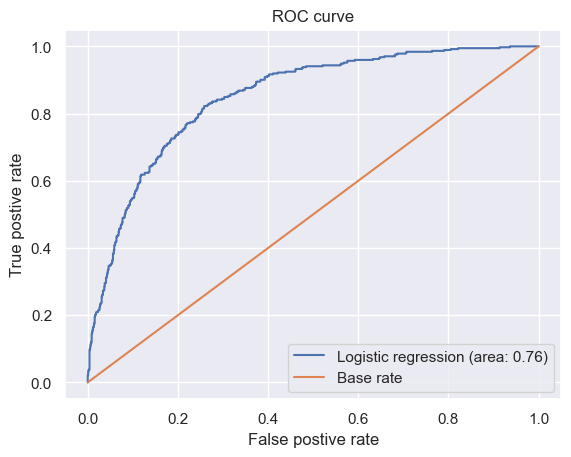

In [194]:
# ROC curve

fpr, tpr, thresold = metrics.roc_curve(y_test, lg_model.predict_proba(x_test)[:][:,1])

plt.plot(fpr,tpr , label = 'Logistic regression (area: %0.2f)' % metrics.roc_auc_score(y_test, lg_predicted))
plt.plot([0,1],[0,1],label = 'Base rate')
plt.xlabel("False postive rate")
plt.ylabel("True postive rate")
plt.title("ROC curve")
plt.legend()

In [195]:
rf_result_1 = cross_val_score(LogisticRegression(), x_train_sm, y_train_sm ,cv=5, scoring = 'accuracy')
print(rf_result_1.mean())

0.8229455280068094


Hence, we tried to predict churn customers using **logistic regression with 75% of the AUROC score**.  